# 6장. 공휴일 효과 예측

## 기본 국가 공휴일 추가(Adding default country holidays)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

df = pd.read_csv('/content/drive/MyDrive/Book7/data/divvy_daily.csv')
df = df[['date', 'rides']]
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y']

model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4)

/tmp/ipython-input-2-3617775803.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


In [ ]:
model.add_country_holidays(country_name='US')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmlkxbo38/f8rh_fe1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmlkxbo38/8iopsdpz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80218', 'data', 'file=/tmp/tmpmlkxbo38/f8rh_fe1.json', 'init=/tmp/tmpmlkxbo38/8iopsdpz.json', 'output', 'file=/tmp/tmpmlkxbo38/prophet_modelsdhm6x7u/prophet_model-20250709074559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:45:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:45:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


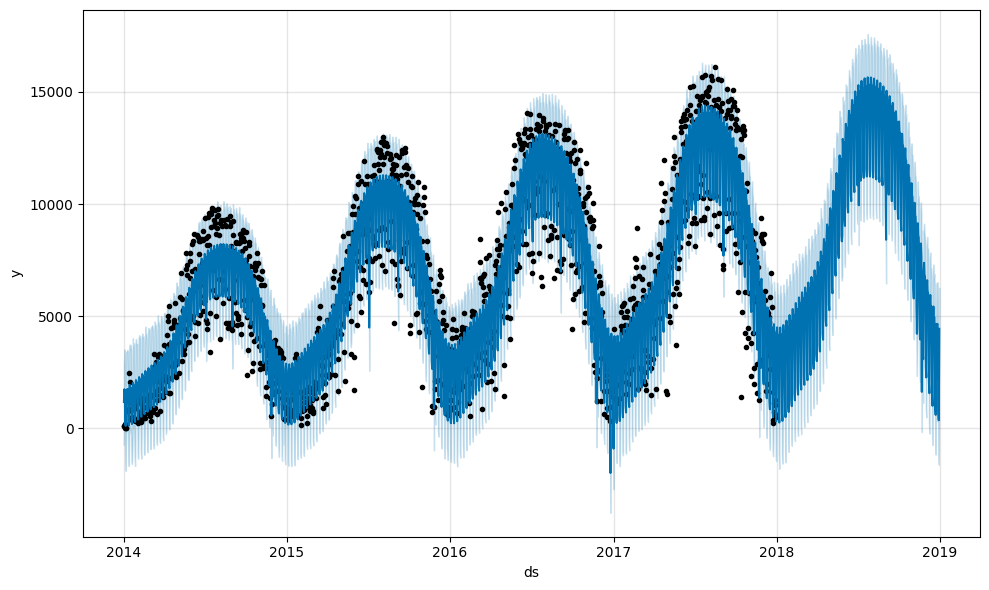

In [ ]:
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

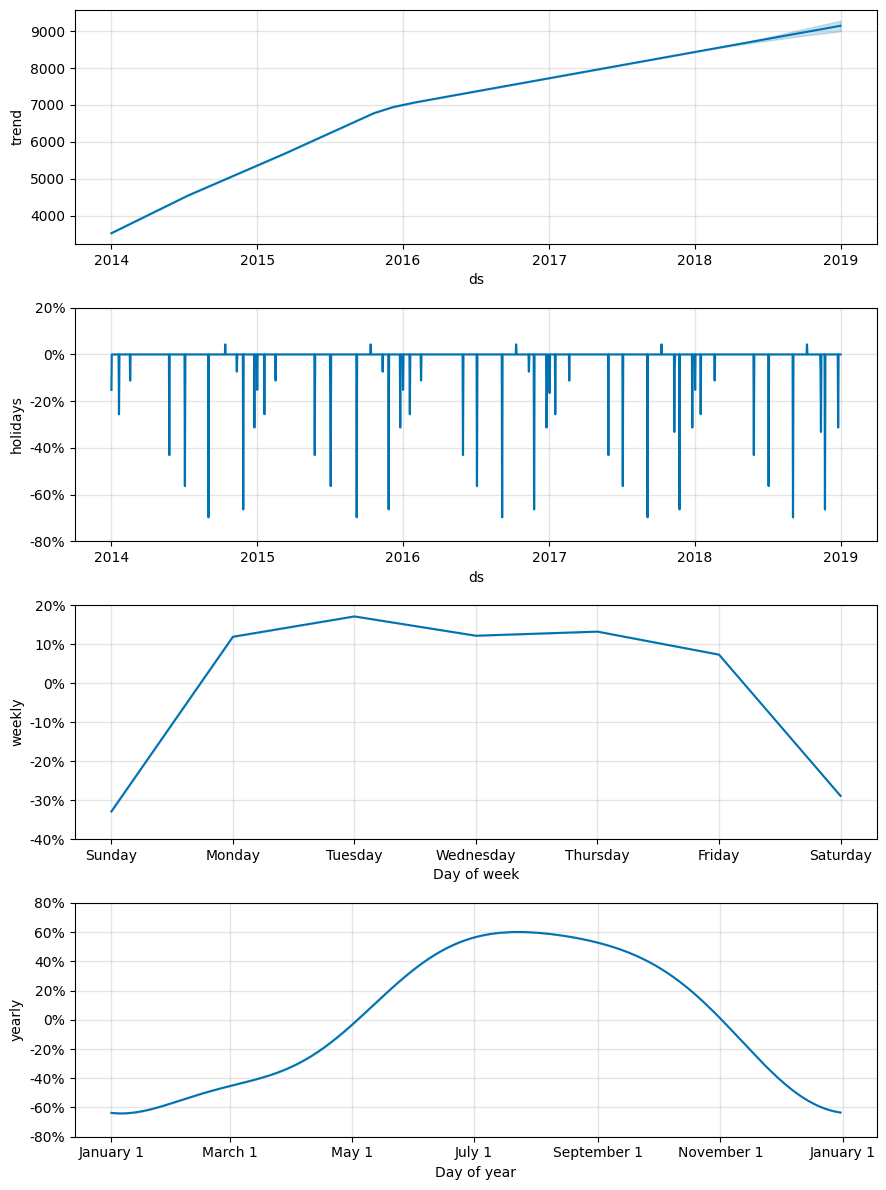

In [ ]:
fig2 = model.plot_components(forecast)
plt.show()

In [ ]:
model.train_holiday_names

,0
0,New Year's Day
1,Memorial Day
2,Independence Day
3,Labor Day
4,Veterans Day
5,Thanksgiving Day
6,Christmas Day
7,Christmas Day (observed)
8,Martin Luther King Jr. Day
9,Washington's Birthday


In [ ]:
def first_non_zero(fcst, holiday):
    return fcst[fcst[holiday] != 0][holiday].values[0]

pd.DataFrame({'holiday': model.train_holiday_names,
              'effect': [first_non_zero(forecast, holiday)
                         for holiday in model.train_holiday_names]})

,holiday,effect
0,New Year's Day,-0.151649
1,Memorial Day,-0.430543
2,Independence Day,-0.563040
3,Labor Day,-0.696629
4,Veterans Day,-0.073596
5,Thanksgiving Day,-0.662743
6,Christmas Day,-0.312541
7,Christmas Day (observed),-0.205772
8,Martin Luther King Jr. Day,-0.255851
9,Washington's Birthday,-0.111737


## 기본 지자체(주/도) 공휴일 추가(Adding default state/province holidays)

In [ ]:
from prophet.make_holidays import make_holidays_df

In [ ]:
year_list = df['ds'].dt.year.unique().tolist()
# 마지막 연도를 확인하고 거기에 1을 더함
year_list.append(year_list[-1] + 1)
holidays = make_holidays_df(year_list=year_list,
                            country='US',
                            state='IL')

In [ ]:
holidays.head()

,ds,holiday
0,2016-01-01,New Year's Day
1,2016-05-30,Memorial Day
2,2016-07-04,Independence Day
3,2016-09-05,Labor Day
4,2016-11-11,Veterans Day


## 연휴 생성(Creating multi-day holidays)

In [ ]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4,
                holidays=holidays)
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmlkxbo38/k_fnvdrb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmlkxbo38/gorko9rf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61392', 'data', 'file=/tmp/tmpmlkxbo38/k_fnvdrb.json', 'init=/tmp/tmpmlkxbo38/gorko9rf.json', 'output', 'file=/tmp/tmpmlkxbo38/prophet_model3tmpiddr/prophet_model-20250709074620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#커스텀 공휴일 생성(Creating custom holidays)

In [ ]:
holidays = make_holidays_df(year_list=year_list, country='US')

In [ ]:
black_friday = pd.DataFrame({'holiday': 'Black Friday',
                             'ds': pd.to_datetime(['2014-11-28',
                                                   '2015-11-27',
                                                   '2016-11-25',
                                                   '2017-11-24',
                                                   '2018-11-23'])})
christmas_eve = pd.DataFrame({'holiday': 'Christmas Eve',
                              'ds': pd.to_datetime(['2014-12-24',
                                                    '2015-12-24',
                                                    '2016-12-24',
                                                    '2017-12-24',
                                                    '2018-12-24'])})

In [ ]:
holidays = pd.concat([holidays, black_friday, christmas_eve]
                    ).sort_values('ds').reset_index(drop=True)

In [ ]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4,
                holidays=holidays)
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmlkxbo38/k5wlfzbt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmlkxbo38/tyqokq3f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9170', 'data', 'file=/tmp/tmpmlkxbo38/k5wlfzbt.json', 'init=/tmp/tmpmlkxbo38/tyqokq3f.json', 'output', 'file=/tmp/tmpmlkxbo38/prophet_modelu7x4oisg/prophet_model-20250709074630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#연휴 생성(Creating multi-day holidays)

In [ ]:
holidays = make_holidays_df(year_list=year_list, country='US')

taste_of_chicago = pd.DataFrame({'holiday': 'Taste of Chicago',
                                 'ds': pd.to_datetime(['2014-07-09',
                                                       '2015-07-08',
                                                       '2016-07-06',
                                                       '2017-07-05',
                                                       '2018-07-11']),
                                 'lower_window': 0,
                                 'upper_window': 4})
holidays = pd.concat([holidays, taste_of_chicago]
                    ).sort_values('ds').reset_index(drop=True)

In [ ]:
holidays.head(10)

,ds,holiday,lower_window,upper_window
0,2014-01-01,New Year's Day,NaN,NaN
1,2014-01-20,Martin Luther King Jr. Day,NaN,NaN
2,2014-02-17,Washington's Birthday,NaN,NaN
3,2014-05-26,Memorial Day,NaN,NaN
4,2014-07-04,Independence Day,NaN,NaN
5,2014-07-09,Taste of Chicago,0.0,4.0
6,2014-09-01,Labor Day,NaN,NaN
7,2014-10-13,Columbus Day,NaN,NaN
8,2014-11-11,Veterans Day,NaN,NaN
9,2014-11-27,Thanksgiving Day,NaN,NaN


In [ ]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4,
                holidays=holidays)
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmlkxbo38/qvlld1de.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmlkxbo38/9as7g0vx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11197', 'data', 'file=/tmp/tmpmlkxbo38/qvlld1de.json', 'init=/tmp/tmpmlkxbo38/9as7g0vx.json', 'output', 'file=/tmp/tmpmlkxbo38/prophet_modelhbw3pl2v/prophet_model-20250709074638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast[forecast['ds'].isin(['2018-07-11',
                              '2018-07-12',
                              '2018-07-13',
                              '2018-07-14',
                              '2018-07-15']
                            )][['ds',
                                'Taste of Chicago']]

/tmp/ipython-input-19-3413789723.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast[forecast['ds'].isin(['2018-07-11',


,ds,Taste of Chicago
1649,2018-07-11,-0.036604
1650,2018-07-12,0.018863
1651,2018-07-13,0.068313
1652,2018-07-14,0.014960
1653,2018-07-15,0.021785


In [ ]:
from prophet.plot import plot_forecast_component

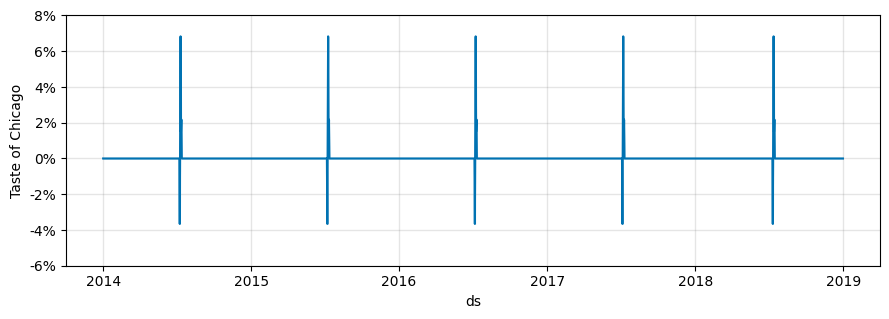

In [ ]:
fig3 = plot_forecast_component(model,
                               forecast,
                               'Taste of Chicago',
                               figsize=(10.5, 3.25))
plt.show()

## 공휴일 규제(Regularizing holidays)

### 전역적 공휴일 규제(Global holiday regularization)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmlkxbo38/9ia78qqy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmlkxbo38/45d4sylm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8347', 'data', 'file=/tmp/tmpmlkxbo38/9ia78qqy.json', 'init=/tmp/tmpmlkxbo38/45d4sylm.json', 'output', 'file=/tmp/tmpmlkxbo38/prophet_modeleiep7imo/prophet_model-20250709074648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


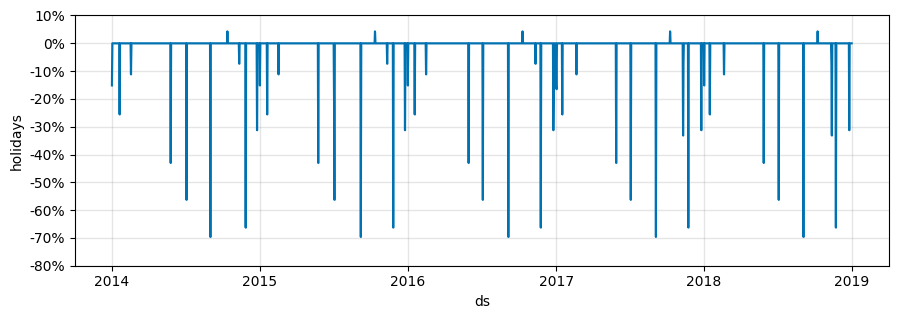

In [ ]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4,
                holidays_prior_scale=10)
model.add_country_holidays(country_name='US')
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig = plot_forecast_component(model,
                              forecast,
                              'holidays',
                              figsize=(10.5, 3.25))
plt.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmlkxbo38/lewvy_6c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmlkxbo38/ug0ocpa5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25816', 'data', 'file=/tmp/tmpmlkxbo38/lewvy_6c.json', 'init=/tmp/tmpmlkxbo38/ug0ocpa5.json', 'output', 'file=/tmp/tmpmlkxbo38/prophet_modelmluz9mz2/prophet_model-20250709074653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


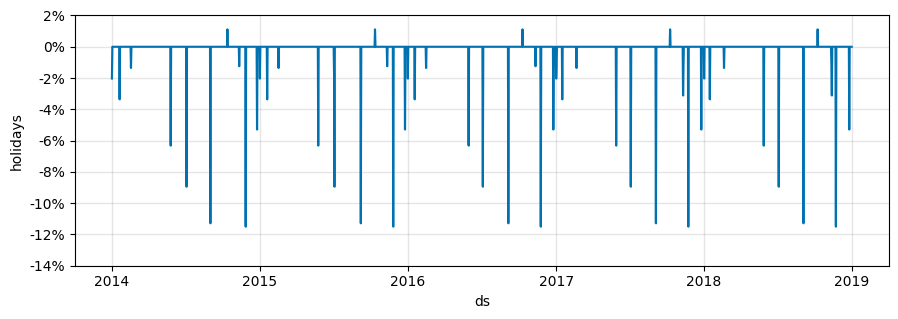

In [ ]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4,
                holidays_prior_scale=0.05)
model.add_country_holidays(country_name='US')
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig = plot_forecast_component(model,
                              forecast,
                              'holidays',
                              figsize=(10.5, 3.25))
plt.show()

### 개별 공휴일 규제(Individual holiday regularization)

In [ ]:
holidays = make_holidays_df(year_list=year_list, country='US')

In [ ]:
black_friday = pd.DataFrame({'holiday': 'Black Friday',
                             'ds': pd.to_datetime(['2014-11-28',
                                                   '2015-11-27',
                                                   '2016-11-25',
                                                   '2017-11-24',
                                                   '2018-11-23']),
                             'prior_scale': 1})
christmas_eve = pd.DataFrame({'holiday': 'Christmas Eve',
                              'ds': pd.to_datetime(['2014-12-24',
                                                    '2015-12-24',
                                                    '2016-12-24',
                                                    '2017-12-24',
                                                    '2018-12-24']),
                              'prior_scale': 1})

taste_of_chicago = pd.DataFrame({'holiday': 'Taste of Chicago',
                                 'ds': pd.to_datetime(['2014-07-09',
                                                       '2015-07-08',
                                                       '2016-07-06',
                                                       '2017-07-05',
                                                       '2018-07-11']),
                                 'lower_window': 0,
                                 'upper_window': 4,
                                 'prior_scale': 0.1})

In [ ]:
holidays = pd.concat([holidays,
                      black_friday,
                      christmas_eve,
                      taste_of_chicago]
                    ).sort_values('ds').reset_index(drop=True)

In [ ]:
holidays.head(16)

,ds,holiday,prior_scale,lower_window,upper_window
0,2014-01-01,New Year's Day,NaN,NaN,NaN
1,2014-01-20,Martin Luther King Jr. Day,NaN,NaN,NaN
2,2014-02-17,Washington's Birthday,NaN,NaN,NaN
3,2014-05-26,Memorial Day,NaN,NaN,NaN
4,2014-07-04,Independence Day,NaN,NaN,NaN
5,2014-07-09,Taste of Chicago,0.1,0.0,4.0
6,2014-09-01,Labor Day,NaN,NaN,NaN
7,2014-10-13,Columbus Day,NaN,NaN,NaN
8,2014-11-11,Veterans Day,NaN,NaN,NaN
9,2014-11-27,Thanksgiving Day,NaN,NaN,NaN


In [ ]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4,
                holidays=holidays,
                holidays_prior_scale=10)
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmlkxbo38/tzd8d81m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmlkxbo38/4cidexxw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82514', 'data', 'file=/tmp/tmpmlkxbo38/tzd8d81m.json', 'init=/tmp/tmpmlkxbo38/4cidexxw.json', 'output', 'file=/tmp/tmpmlkxbo38/prophet_model2_9ni0tl/prophet_model-20250709074706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:47:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:47:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
